In [208]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from pylab import rcParams

# setting a default figure size for timeseries plots

rcParams['figure.figsize'] = 12,4

# data from https://fred.stlouisfed.org/series/UNRATE

# Notes from source website:

# Units:  Percent, Seasonally Adjusted

# Frequency:  Monthly

# 'The unemployment rate represents the number of unemployed as a percentage of the labor force. 
# Labor force data are restricted to people 16 years of age and older, who currently reside in 1 of the 50 
# states or the District of Columbia, who do not reside in institutions 
# (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.''

df = pd.read_csv('UNRATE.csv')
df.dropna(inplace = True)
df.rename(columns = {'DATE': 'date','UNRATE': 'unemployment_rate'}, inplace = True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)


# setting the sampling frequency to months
df.index.freq = 'MS'

df


,unemployment_rate
date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2019-11-01,3.5
2019-12-01,3.5
2020-01-01,3.6


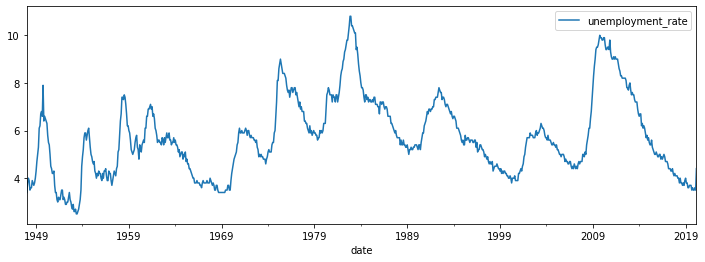

In [209]:
# plotting the time series 

df.plot(figsize = (12,4))

Text(0, 0.5, '% unemployed')

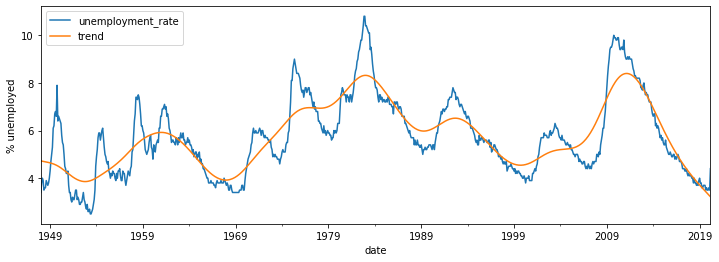

In [210]:
# decomposing the time series into a trend and cycle component using statsmodels Hodrick-Prescott filter

hpfilter = sm.tsa.filters.hpfilter

cycle, trend = hpfilter(df['unemployment_rate'], lamb = 129600)

df['trend'] = trend
df['cycle'] = cycle

df[['unemployment_rate', 'trend']].plot().set_ylabel('% unemployed')


Text(0, 0.5, '% unemployed')

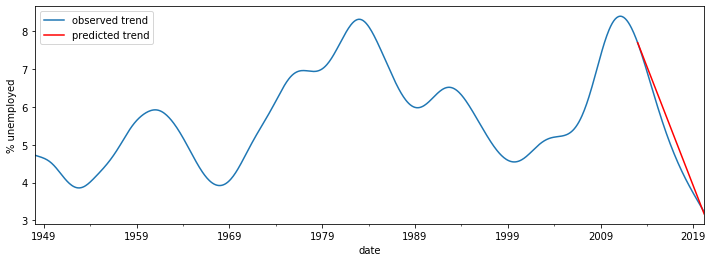

In [231]:
# training a Holt-Winters Exponential Smoothing model on 90% of the observed trend time series. Then using it to predict
# the last 10% of the time series

train_sample_trend = df['trend'].iloc[:-round((len(df.index)*.10))]

hw_trend_mod = statsmodels.tsa.holtwinters.ExponentialSmoothing(train_sample_trend, trend = 'add',
                                                         seasonal = 'add')
hw_trend_mod = hw_trend_mod.fit(optimized = True)

trend_prediction = hw_trend_mod.forecast(round(len(df.index)*.10))

df['trend'].plot(label = 'observed trend', legend = True)
trend_prediction.plot(label = 'predicted trend', legend = True, color = 'red').set_ylabel('% unemployed')